In [10]:
import warnings
warnings.filterwarnings('ignore')

# Install required libraries, upgrading wfdb and ensuring compatible numpy
!pip install --upgrade --no-cache-dir wfdb PyWavelets scipy matplotlib 'numpy==1.26.0' 'pandas==2.2.2'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 3.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of wfdb to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 250.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 234.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 135.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 175.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.4.1
    Uninstalling numpy-2.4.1:
      Successfully uninstalled numpy-2.4.1
  Attempting uninstall: scipy
    Found existing installation: scipy 1.17.0
    Uninstalling scipy-1.17.0:
      Successfully uninstalled scipy-1.17.0
ERROR: pip's dep

In [3]:
!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/
!mv physionet.org/files/mitdb/1.0.0 /content/mitbih

Streaming output truncated to the last 5000 lines.
Saving to: ‘physionet.org/files/mitdb/1.0.0/223.atr’

physionet.org/files 100%[===================>]   5.34K  --.-KB/s    in 0s      

2026-01-26 16:16:42 (2.26 GB/s) - ‘physionet.org/files/mitdb/1.0.0/223.atr’ saved [5468/5468]

--2026-01-26 16:16:42--  https://physionet.org/files/mitdb/1.0.0/223.dat
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1950000 (1.9M) [application/octet-stream]
Saving to: ‘physionet.org/files/mitdb/1.0.0/223.dat’

physionet.org/files 100%[===================>]   1.86M   385KB/s    in 4.9s    

2026-01-26 16:16:47 (390 KB/s) - ‘physionet.org/files/mitdb/1.0.0/223.dat’ saved [1950000/1950000]

--2026-01-26 16:16:47--  https://physionet.org/files/mitdb/1.0.0/223.hea
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 258 [text/plain]
Saving to: ‘physionet.org/files/mitdb/1.0.0/223.hea’

physionet.org/f

In [4]:
import os
print("MIT-BIH files count:", len(os.listdir('/content/mitbih')))

MIT-BIH files count: 10


1. **Loading Raw Dataset**

This code loads a raw ECG recording from the MIT-BIH Arrhythmia Database using the rdsamp() function. It extracts the MLII lead signal, which is the primary channel used for arrhythmia analysis. The shape of the ECG signal is printed to confirm successful loading. Finally, the first 2000 samples of the raw ECG waveform are plotted to visualize the unprocessed signal before applying any preprocessing steps

Raw ECG shape: (650000,)


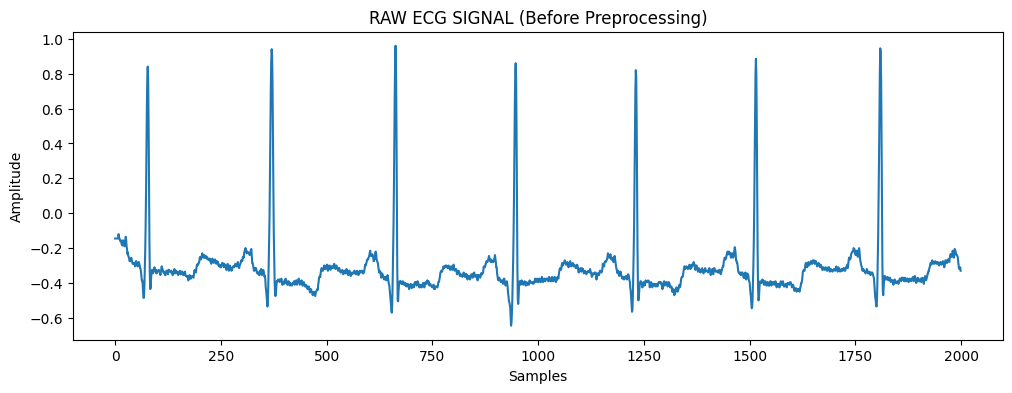

In [2]:
from wfdb import rdsamp
import matplotlib.pyplot as plt
import numpy as np

signal, fields = rdsamp('/content/mitbih/100')
ecg = signal[:,0]   # MLII channel

print("Raw ECG shape:", ecg.shape)

# ---- BEFORE plot ----
plt.figure(figsize=(12,4))
plt.plot(ecg[:2000])
plt.title("RAW ECG SIGNAL (Before Preprocessing)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

2 . **Wavelet Denoising** :
This code performs wavelet-based denoising on the raw ECG signal using a Daubechies-4 (db4) wavelet with four levels of decomposition. High-frequency noise components are removed by zeroing the detail coefficients, and the signal is then reconstructe

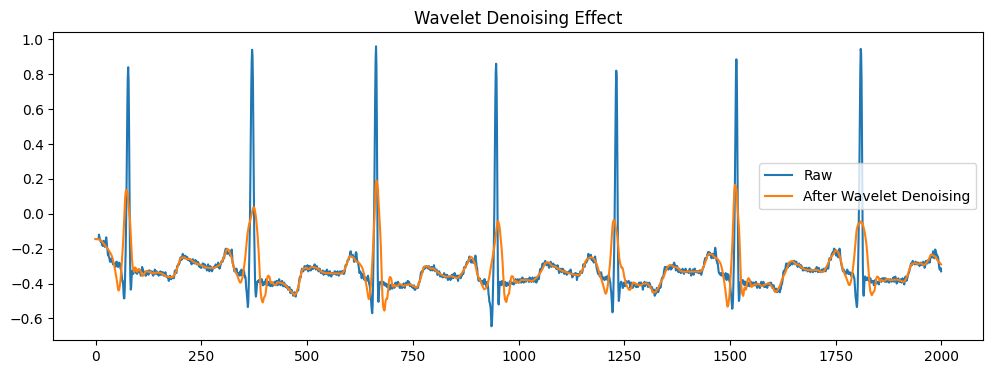

In [3]:
import pywt

def wavelet_denoise(sig):
    coeffs = pywt.wavedec(sig, 'db4', level=4)
    coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]]  # remove high freq noise
    rec = pywt.waverec(coeffs, 'db4')
    return rec[:len(sig)]

denoised = wavelet_denoise(ecg)

# ---- BEFORE vs AFTER ----
plt.figure(figsize=(12,4))
plt.plot(ecg[:2000], label="Raw")
plt.plot(denoised[:2000], label="After Wavelet Denoising")
plt.legend()
plt.title("Wavelet Denoising Effect")
plt.show()


3. **Baseline Drift Removal (IIR Zero-phase filter)** : This code removes baseline drift from the denoised ECG signal using a high-pass Butterworth IIR filter with zero-phase filtering. The filter suppresses low-frequency variations caused by respiration and electrode movement while preserving the main ECG waveform

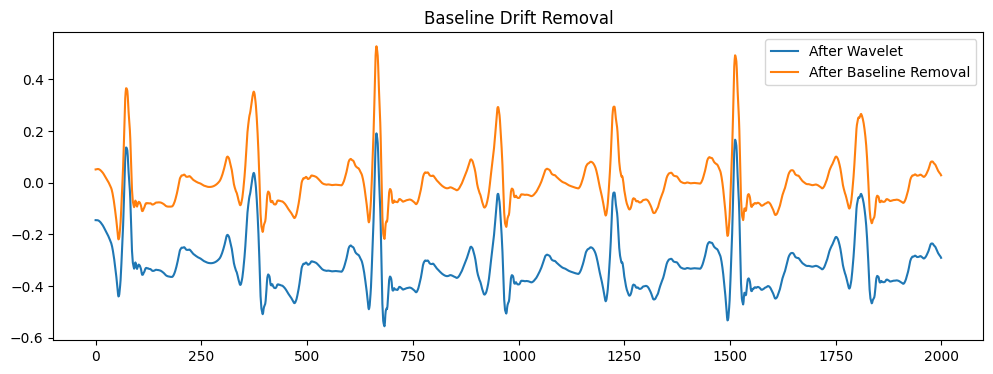

In [4]:
from scipy.signal import butter, filtfilt

def remove_baseline(sig, fs=360):
    b, a = butter(2, 0.5/(fs/2), btype='highpass')
    return filtfilt(b, a, sig)

baseline_corrected = remove_baseline(denoised)

# ---- BEFORE vs AFTER ----
plt.figure(figsize=(12,4))
plt.plot(denoised[:2000], label="After Wavelet")
plt.plot(baseline_corrected[:2000], label="After Baseline Removal")
plt.legend()
plt.title("Baseline Drift Removal")
plt.show()


4. **R-Peak Detection (using MIT-BIH annotations)** : This code loads the annotation file associated with the ECG record from the MIT-BIH dataset and extracts the sample indices of R-peaks, which were originally detected using the Pan–Tompkins algorithm. These R-peak locations represent the positions of QRS complexes in the ECG signal and are used as reference points for heartbeat segmentation in later preprocessing steps.

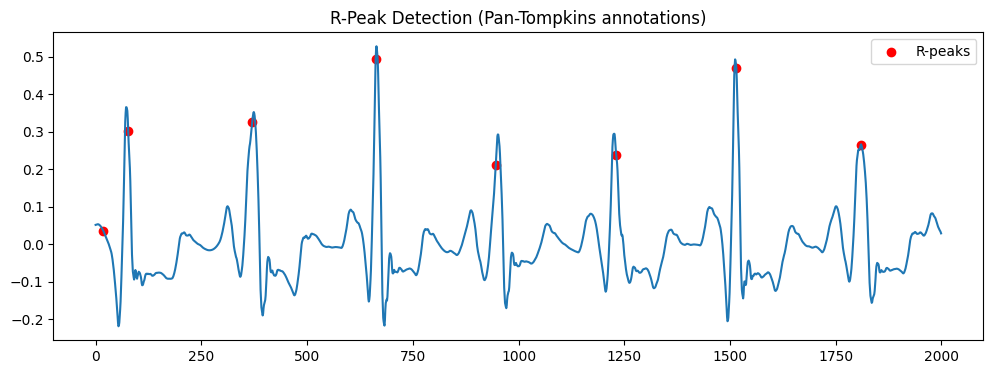

In [9]:
from wfdb import rdann
import matplotlib.pyplot as plt

ann = rdann('/content/mitbih/100', 'atr')
r_peaks = ann.sample

# ---- Plot R-peaks ----
plt.figure(figsize=(12,4))
plt.plot(baseline_corrected[:2000])
plt.scatter(r_peaks[r_peaks<2000],
            baseline_corrected[r_peaks[r_peaks<2000]],
            color='red', label="R-peaks")
plt.legend()
plt.title("R-Peak Detection (Pan-Tompkins annotations)")
plt.show()

5. **Heartbeat Segmentation (0.75s window = 270 samples)** : This code segments individual heartbeats from the baseline-corrected ECG signal using the detected R-peak locations as reference points. For each R-peak, a fixed window of 270 samples (corresponding to 0.75 seconds at a 360 Hz sampling rate) is extracted, ensuring that each segment contains one complete heartbeat cycle. The collected heartbeat segments are stored as a NumPy array to form the input samples for further normalization and model training.

Segmented heartbeats shape: (2271, 270)


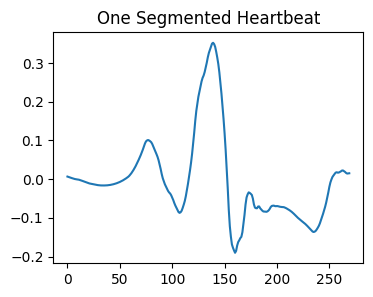

In [6]:
segments = []
for r in r_peaks:
    start = r - 135
    end = r + 135
    if start >= 0 and end < len(baseline_corrected):
        segments.append(baseline_corrected[start:end])

segments = np.array(segments)
print("Segmented heartbeats shape:", segments.shape)

# ---- Plot one heartbeat ----
plt.figure(figsize=(4,3))
plt.plot(segments[0])
plt.title("One Segmented Heartbeat")
plt.show()


6. **Normalization (0–1 Min-Max Scaling)**

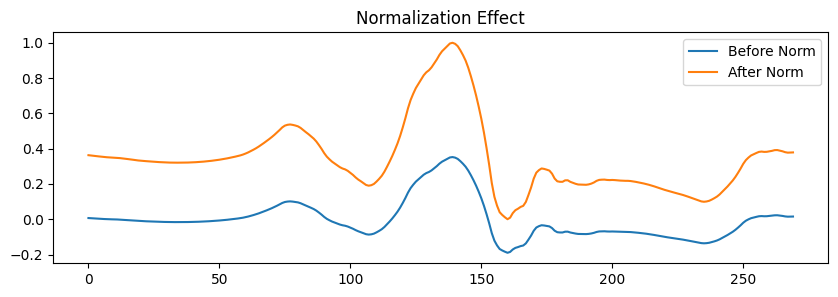

In [7]:
def normalize(sig):
    return (sig - np.min(sig)) / (np.max(sig) - np.min(sig))

normalized_segments = np.array([normalize(s) for s in segments])

# ---- BEFORE vs AFTER ----
plt.figure(figsize=(10,3))
plt.plot(segments[0], label="Before Norm")
plt.plot(normalized_segments[0], label="After Norm")
plt.legend()
plt.title("Normalization Effect")
plt.show()

In [8]:
np.save("ecg_preprocessed.npy", normalized_segments)
print("Saved file: ecg_preprocessed.npy")
print("Final dataset shape:", normalized_segments.shape)

Saved file: ecg_preprocessed.npy
Final dataset shape: (2271, 270)
